<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/LibraryNet/libraries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries (test)

Author: Maxim Ziatdinov

Contact e-mail: ziatdinovmax@gmail.com

Here we are going to use a deep neural network and simple analysis of lattice graph structures to create a library of Si pont defects in graphene. The defects are categorized based on the number of atoms in the first coordination sphere of each detected dopant. This analysis should also work for other systems (but will require a different training set for a neural network) with a known impurity atom in a host lattice, which can have different configurations (e.g. dimer, trimer, different number of bonds to the nearby host lattice atoms, etc.). Please also check [this notebook](https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/AtomNet/GrapheneAtomFinder.ipynb) for the best practices of applying deep neural network to atom finding/categorization in the noisy experimental data.

To run it in Colab, first execute the cell below:

(alternatively, you can run it with a Jupyter Lab/Notebook on your local machine)

In [1]:
%%shell
git clone https://github.com/pycroscopy/AICrystallographer.git
cp -r AICrystallographer/LibraryNet/* .

Cloning into 'AICrystallographer'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 803 (delta 81), reused 238 (delta 40), pack-reused 518
Receiving objects: 100% (803/803), 129.61 MiB | 30.02 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (219/219), done.


Import modules:

In [0]:
import glob
import numpy as np
import dcnn
from atomfind import *
import graphs
from utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", module="networkx")

We first get a list of filepaths for the test data. Here we store our data in the hdf5 file format with a very simple structure. Specifically, it containce only two datasets: a single experimental image in the form of 2d numpy array and metadata in the json format.

In [3]:
filelist = glob.glob('test_data/*.hdf5')
filelist

['test_data/test-2.hdf5', 'test_data/test-1.hdf5']

We need to specify the host lattice atoms (here, it is graphene, hence 'C') and the dopant atoms (here it is 'Si'). We also need to specify maximum possible bond lengths between these atomic species (if we don't do it here, we will be promted to enter those values when running the analysis).

In [0]:
atoms = OrderedDict()
atoms['lattice_atom'] = 'C'
atoms['dopant'] = 'Si'
approx_max_bonds = {('Si', 'Si'): 250, ('C', 'C'): 175, ('Si', 'C'): 210}

Finally we can run the analysis and obtain information on the type of atomic defects in our system within just several seconds. Each analyzed defect is stored in the folder whose name correspond to a defect class. The files are saved in the hdf5 file format and contain a dataset corresponding to the image and a dataset corresponding to the defect(s) coordinates. Noice that here we will be asked to choose whether to save file or not (although this option can be disabled), which allows for a domain expert to double check the output. That said, for the very large amounts of data, such manual confirmation may not be feasible. In that case, set *save_all=True* in the *graphs.construct_graphs* function.

Loaded 1 image of the size 256 by 256
Sample name: Graphene monolayer
Type of experiment: HAADF
1 image was decoded in approximately 0.09 seconds
Atomic/defect coordinates extracted


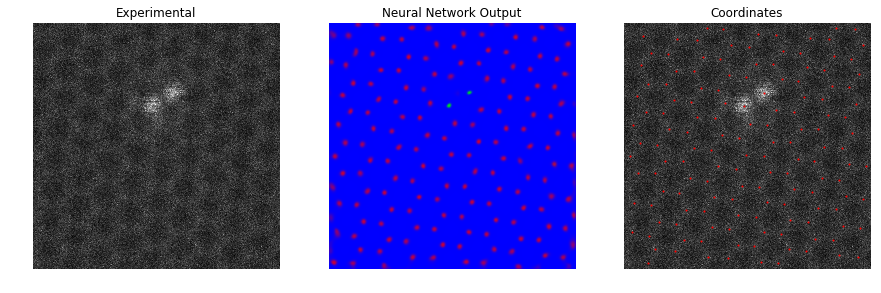

Found the following atomic species: C, Si
Created 143 graph nodes corresponding to atomic species
All lattice atoms not directly connected to a dopant have been removed
Refinement procedure based on the maximum coordination number has been completed


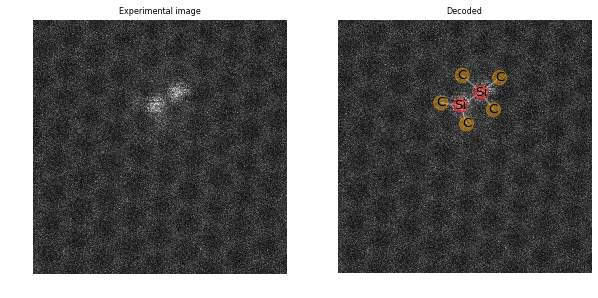


Identified 1 defect structures
Defect 1:
 Defect formula: Si2C5 Defect position: [135.69, 78.72]
Save data: [Y]es or [N]o
Y
Saved file with defect coordinates to disk

Loaded 1 image of the size 256 by 256
Sample name: Graphene monolayer
Type of experiment: HAADF
1 image was decoded in approximately 0.02 seconds
Atomic/defect coordinates extracted


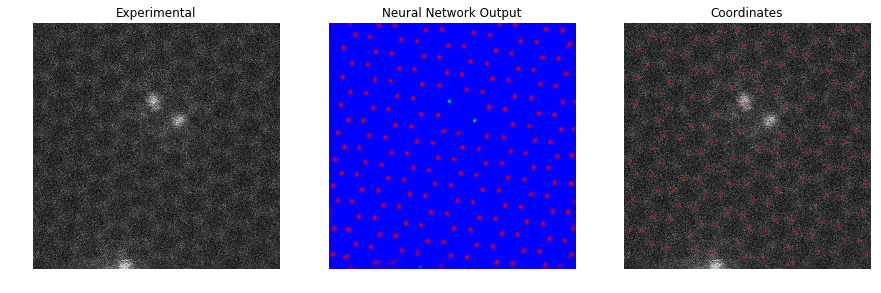

Found the following atomic species: C, Si
Created 170 graph nodes corresponding to atomic species
All lattice atoms not directly connected to a dopant have been removed
Refinement procedure based on the maximum coordination number has been completed


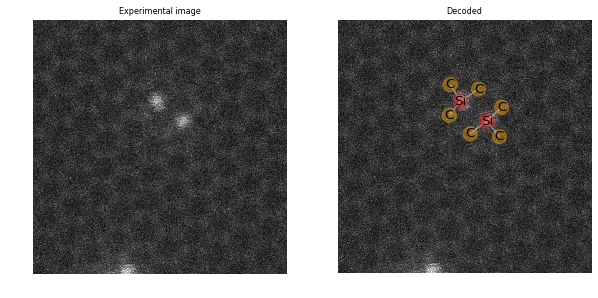


Identified 2 defect structures
Defect 1:
 Defect formula: Si1C3 Defect position: [123.19, 78.12]
Save data: [Y]es or [N]o
Y
Saved file with defect coordinates to disk

Defect 2:
 Defect formula: Si1C3 Defect position: [153.34, 105.49]
Save data: [Y]es or [N]o
Y
Saved file with defect coordinates to disk



In [5]:
# Folder and filename for the saved weights
weights_folder = './saved_models/'
weights_file = 'G-Si-m-2-3-best_weights.pt'
# Load model skeleton
model = dcnn.atomsegnet(nb_classes=3)
# Load trained weights
model = dcnn.load_torchmodel(weights_folder+weights_file, model)
# iterate over files with image data
for filename in filelist:
    imgdata, metadata = open_hdf(filename)
    img_size = metadata['scan size']
    # Apply a trained model to the loaded data
    img, dec = dl_image(imgdata, model, nb_classes=3).decode()
    # Get atomic coordinates
    coord = find_atoms(dec).get_all_coordinates()
    # plot results of dcnn based decoding
    y, x,_ = coord[0].T
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img[0, :, :, 0], cmap='gray')
    ax[0].set_title('Experimental')
    ax[1].imshow(dec[0, :, :, :], cmap='jet', Interpolation='Gaussian')
    ax[1].set_title('Neural Network Output')
    ax[2].imshow(img[0, :, :, 0], cmap='gray')
    ax[2].scatter(x, y, s=1, c='red')
    ax[2].set_title('Coordinates')
    for _ax in fig.axes:
        _ax.axis('off')
    plt.show()
    # construct and plot graph
    if len(coord[0]) > 0:
        graphs.construct_graphs(img, img_size, coord[0], atoms,
                         approx_max_bonds, filename)

We can then read the saved files and display both the images and coordinates: 

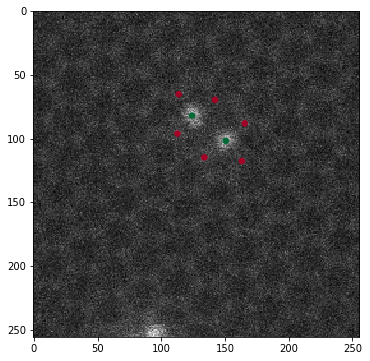

In [6]:
# Specify filepath
path = 'library_test/Si1C3/'
library_file = 'test-1.hdf5'
# read data (image+defect coordinates)
img, img_size, coord = open_library_hdf(path+library_file, atoms)
# plot image and defect cordinates
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img[0, :, :, 0], cmap = 'gray')
ax.scatter(coord[:, 1], coord[:, 0], c = coord[:, 2]+1, s=30, cmap='RdYlGn')

We can also easily reconstruct subgraphs associated with defects. We just need to specify *raw_data=False* to indicate that we are viewing a library data and not a new raw input.

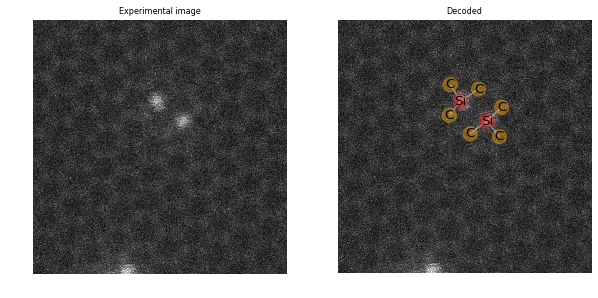

In [7]:
defects = graphs.construct_graphs(img, img_size, coord, atoms,
                                  approx_max_bonds, raw_data=False,
                                  verbose=False)

We can also introduce subcategories to distringuish defects that have the same formula but different degree of distortion. It makes sense to do it mostly for those defects where a undistorted structure is well known. In this case it is a Si1C3 defect class. Let's get information on the bond angles and bond lengths for Si1C3 defects that we just loaded:

In [8]:
for i, sg in enumerate(defects):
    print('Defect {} Si-C angles:'.format(i+1), 
          graphs.get_angles(sg, atoms['dopant']))
    print('Defect {} Si-C bonds (pm):'.format(i+1),
          graphs.get_bond_lengths(sg, atoms['dopant'], img_size, img))      

Defect 1 Si-C angles: [ 87.60450926 163.11897621 109.27651453]
Defect 1 Si-C bonds (pm): [141.44104587 154.62380325 171.13588415]
Defect 2 Si-C angles: [ 91.14035574 174.91103462  93.94860964]
Defect 2 Si-C bonds (pm): [158.2543561  158.44499692 165.16328866]


One can see that there is a large variation in the bond angles. Let's identify a threshold above which a defect is categorized as 'distorted' and run a binary classification for each defect ('distorted' vs. 'undistorted')

In [0]:
import os
from collections import Counter
# Define a criterion to separate distorted defects.
def criterion():
    return np.std(graphs.get_angles(sg, atoms['dopant'])) > 15
# Iterate over defects in the image
for i, sg in enumerate(defects):
    atom_list = []
    for n in sg.nodes():
        atom_list.append(n.split(' ')[0])
    n_imp = Counter(atom_list)[atoms['dopant']]
    n_host = Counter(atom_list)[atoms['lattice_atom']]
    defect_formula = atoms['dopant'] + str(n_imp) + atoms['lattice_atom'] + str(n_host)
    defect_position, defect_coord = graphs.get_defect_coord(sg)
    # Binary classification based on a defined criterion
    if criterion():
        filepath = 'library_test/' + defect_formula + '_distorted'
    else:
        filepath = 'library_test/' + defect_formula + '_undistorted'
        # Create a directory for each defect formula
    if not os.path.exists(filepath):
            os.makedirs(filepath)
    # save hdf5 file with original and decoded data
    with h5py.File(os.path.join(filepath, library_file), 'a') as f:
        if 'nn_input' not in f.keys():
            nn_input = f.create_dataset('nn_input', data=img)
            nn_input.attrs['scan size'] = img_size
        if 'defect_coord_{}'.format(i) not in f.keys():
            f.create_dataset('defect_coord_{}'.format(i),
                             data=np.string_(defect_coord, encoding="utf-8"))

Finally, we are going to show how a constructed library of defects can be used to analyze strain and "regions of stability" in the experimentally observed defects. To do this, we will need an ideal, fully-relaxed structure of a defect from density functional theory calculations. We have already performed such calculations and so we will just load the calculated data for Si1C3 defect for 0%, 5%, 10%, 15% and 20% of tensile strain. 

In [0]:
defect_calculated = np.load('Si1C3-tensile_strain-DFT.npy', allow_pickle=True)[()]
defect_ideal = defect_calculated.pop('0')

We now get a list of files from library of experimental results for the same type of defect:

In [0]:
filelist_exp = glob.glob('library_refined/Si1C3/*.hdf5')

We calculate strain components ($e_{xx}$ and $e_{yy}$) for experimental data:

In [0]:
# lists to store diagonal strain values
exx_exp, eyy_exp = [], []
calibration = 1.03
for hf in filelist_exp:
    # get data from a library file
    imgdata, img_size, coord_all = open_library_hdf(hf, atoms)
    # reconstruct all the defects in the image/file
    defects = graphs.construct_graphs(
                    imgdata, img_size, coord_all, atoms,
                    approx_max_bonds, raw_data=False,
                    plot_result=False, verbose=False
    )
    # iterate over the defects in the image/file
    for sg in defects:
        # get defect coordinate
        _, coord_all = graphs.get_defect_coord(sg)
        coord_xy = np.array(coord_all[:, :2], dtype=np.float)
        # change coordinates to angstroms
        img_size_ = img_size/100
        px2ang = img_size_/imgdata.shape[1]
        coord_xy = px2ang*coord_xy*calibration
        # calculate strain function
        output = strainfunction(defect_ideal[:, 0:2], coord_xy)
        # if strain calculations were successfull add to list
        if output is not None:
            exx_exp.append(output['strain_tensor'][0, 0])
            eyy_exp.append(output['strain_tensor'][1, 1])

We can also calculate the strain components for theoretical data:

In [0]:
# lists to store diagonal strain values
exx_theory, eyy_theory = [], []
# iterate over dictionary items with calculated strain values
for v in defect_calculated.values():
    output = strainfunction(defect_ideal[:, 0:2], v[:, 0:2])
    # if strain calculations were successfull add to list
    if output is not None:
        exx_theory.append(output['strain_tensor'][0, 0])
        eyy_theory.append(output['strain_tensor'][1, 1])

Finally, we plot them together:

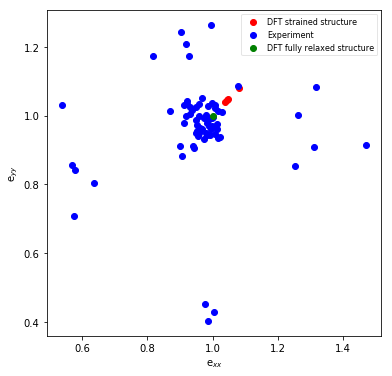

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(exx_theory, eyy_theory, c ='red', label='DFT strained structure')
ax.scatter(exx_exp, eyy_exp, c='blue', label='Experiment')
ax.scatter(1, 1, c = 'green', label='DFT fully relaxed structure')
ax.set_xlabel('e$_{xx}$')
ax.set_ylabel('e$_{yy}$')
ax.legend(loc='best', fontsize=8, framealpha=0.5)

The outliers in this analysis typically correspond to Si1C3 defects next to holes and/or topological defects.

In summary, we have shown how to construct a library of atomic defects from raw STEM data, how to open saved library files, how to split them further into different subcategories (distorted/undistorted) and how to use library data to explore strain and regions of stability of different defects.